<a href="https://colab.research.google.com/github/danielpatrickhug/Sentence_Kernels/blob/main/github_repo_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install requirements and updating python version to 3.10


In [41]:
%%capture
%%bash
pip install openai
pip install sentence-transformers
pip install bertopic
pip install matplotlib

### make sure to restart runtime

In [2]:
%%capture
%%bash
#install python 3.9 and dev utils
#you may not need all the dev libraries, but I haven't tested which aren't necessary.
sudo apt-get update -y
sudo apt-get install python3.10 python3.10-dev python3.10-distutils libpython3.10-dev

#change alternatives
sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10 2

#Check that it points at the right location
python3 --version

# install pip
curl https://bootstrap.pypa.io/get-pip.py -o get-pip.py
python3 get-pip.py --force-reinstall

#install colab's dependencies
python3 -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor

# link to the old google package
ln -s /usr/local/lib/python3.8/dist-packages/google \
       /usr/local/lib/python3.10/dist-packages/google

# There has got to be a better way to do this...but there's a bad import in some of the colab files
# IPython no longer exposes traitlets like this, it's a separate package now
sed -i "s/from IPython.utils import traitlets as _traitlets/import traitlets as _traitlets/" /usr/local/lib/python3.10/dist-packages/google/colab/*.py
sed -i "s/from IPython.utils import traitlets/import traitlets/" /usr/local/lib/python3.10/dist-packages/google/colab/*.py

In [3]:
!python --version

Python 3.10.10


## Imports

In [42]:
import ast
import astor
from getpass import getpass
import openai
import os
import inspect
import json
import scipy
import scipy.stats
import numpy as np
from bertopic import BERTopic
from bertopic.representation import OpenAI
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

## OpenAI key

In [3]:
openai_secret = getpass('Enter the secret value: ')
# Set up OpenAI API credentials
openai.api_key = openai_secret

Enter the secret value: ··········


## Download Repo of interest

In [4]:
%%capture
%%bash
git clone https://github.com/MaartenGr/BERTopic.git

In [ ]:
%%capture
%%bash
git clone https://github.com/LAION-AI/riverbed.git

In [ ]:
%%capture
%%bash
git clone -b feature/data-quality-pipeline-hfdataset https://github.com/kenhktsui/Open-Assistant.git

## Parse Repo Dir and extract Imports, Globals, Classes(methods), Functions

In [5]:
import os
import ast

def parse_python_file(file_path):
    parsed_contents = {"imports": [], "globals": [], "classes": [], "functions": [],}

    with open(file_path, "r") as file:
        file_contents = file.read()
        parsed_tree = ast.parse(file_contents)

    for node in ast.iter_child_nodes(parsed_tree):
        if isinstance(node, ast.Import) or isinstance(node, ast.ImportFrom):
            parsed_contents["imports"].append(astor.to_source(node).strip())
        elif isinstance(node, ast.Assign) and len(node.targets) == 1 and isinstance(node.targets[0], ast.Name):
            parsed_contents["globals"].append(astor.to_source(node).strip())
        elif isinstance(node, ast.FunctionDef):
            if node.name == "main":
                parsed_contents["functions"].append(ast.get_source_segment(file_contents, node))
            else:
                parsed_contents["functions"].append(ast.get_source_segment(file_contents, node))
        elif isinstance(node, ast.ClassDef):
            parsed_contents["classes"].append(ast.get_source_segment(file_contents, node))

    return parsed_contents

def get_methods(class_or_str):
    if isinstance(class_or_str, str):
        class_or_str = ast.parse(class_or_str)

    method_nodes = [node for node in ast.iter_child_nodes(class_or_str) if isinstance(node, ast.FunctionDef)]
    method_sources = []
    for node in method_nodes:
        source_lines, _ = ast.get_source_segment(class_or_str, node)
        method_sources.append(''.join(source_lines).strip())
    return method_sources

def parse_github_repo(local_dir):
    parsed_files = []
    content_labels = {0: "imports", 1:"globals", 2: "classes", 3: "functions", 4: "main", 5: "file_name"}

    for root, dirs, files in os.walk(local_dir):
        for file_name in files:
            if file_name.endswith(".py"):
                file_path = os.path.join(root, file_name)
                parsed_contents = parse_python_file(file_path)
                content = {content_labels[i]: v for i, v in enumerate(parsed_contents.values())}
                content[content_labels[5]] = file_path
                parsed_files.append(content)

    return parsed_files


## Assistant Tasks

In [6]:
def format_system_prompts(git_repo_path, file_name):
    system_prompts = {
        "summary": f"""
                    Summarize the code the GitHub repository: {git_repo_path} you're currently in the file {file_name}
                    ChatGPT will use its advanced natural language processing capabilities to analyze the code and generate a concise summary that captures
                    the main functionality and purpose of the codebase. Additionally, ChatGPT can provide insights into the programming languages and libraries used in the repository,
                    as well as any notable features or functionalities that are present. Simply provide the necessary information, and let ChatGPT do the rest! 
                    """,
        "bug_finder": f"""
                    Help identify bugs in the codebase of the GitHub repository: {git_repo_path} you're currently in the file {file_name}.
                    ChatGPT will analyze the codebase to identify potential bugs and provide suggestions on how to fix them.
                    Let ChatGPT assist you in your debugging efforts and make your code more robust and reliable.
                    """,
        "todo_labeler": f"""
                    Automatically label and generate TODO comments in the codebase of the GitHub repository: {git_repo_path} you're currently in the file {file_name}.
                    ChatGPT will scan the codebase for any potential TODO tasks and categorize them based on their priority and complexity.
                    Let ChatGPT help you stay organized and on top of your development tasks.
                    """,
        "code_suggestions": f"""
                    Get suggestions for improving the codebase of the GitHub repository: {git_repo_path} you're currently in the file {file_name}.
                    ChatGPT will analyze the codebase and provide suggestions for improving the code quality, optimizing performance, and enhancing functionality.
                    Let ChatGPT help you take your codebase to the next level.
                    """,
        "question_asking": f"""
                    Ask ChatGPT questions about the codebase of the GitHub repository: {git_repo_path} you're currently in the file {file_name}.
                    ChatGPT asks questions that a new developer may ask about the codebase used in the repository, 
                    as well as answer the question with step by step reasoning as a senoir dev would. All responses should first ask a question and then answer with reasoning.
                    """,
        "complement_code": f"""
                    Give compliments on the codebase of the GitHub repository: {git_repo_path} you're currently in the file {file_name}.
                    ChatGPT will analyze the codebase and provide positive feedback on the structure, organization, readability, and other aspects of the code.
                    Let ChatGPT help you feel good about your code and celebrate your accomplishments!
                    """,
        "translate_python_to_rust": f"""
                    Translate Python code in the GitHub repository: {git_repo_path} you're currently in the file {file_name} to Rust.
                    ChatGPT will use its natural language processing capabilities to translate Python code snippets to Rust code.
                    Let ChatGPT help you understand Python code and communicate more effectively with your team in Rust.
                    """
    }
    return system_prompts


## Inference

In [8]:

def chat_gpt_inference(messages: list):
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=messages,
        max_tokens=300,
        temperature=0
    )
    return response

def create_prompt_message_template(text, role="user"):
    if role not in ["user", "assistant"]:
        raise ValueError("Not a valid role. Please use 'user' or 'assistant'.")
    return {"role": role, "content": text}

def compose_inference(text_block, messages):
    user_template = create_prompt_message_template(text_block, role="user")
    messages.append(user_template)
    chat_resp = chat_gpt_inference(messages)
    reply_text = chat_resp['choices'][0]['message']['content']
    assistant_template = create_prompt_message_template(reply_text, role="assistant")
    messages.append(assistant_template)
    return messages, reply_text
    
def process_transcript(segments, file_name, git_repo_path, output_file_path, system_prompt, task, code_type):
    buffer = []
    
    messages = [{"role": "system", "content": system_prompt}]
    running_size = 0
    with open(output_file_path, 'a') as f:
        for i, sent in enumerate(segments):
            text_block = f"""```{sent}```"""
            
            messages, reply_text = compose_inference(text_block[:2000], messages)
            #print(reply_text)
            row = {"git_repo_path": git_repo_path, "file_name": file_name, "code_type": code_type, "system_task": task, "system_prompt": system_prompt, "conversation_history": messages, "assistant_reply": reply_text}
            json.dump(row, f)
            f.write("\n")
            
    return messages

In [11]:
git_repo_path = "/content/BERTopic/bertopic"
out_path = "/content/bertopic_"
name_id = "bertopic_"
contents = parse_github_repo(git_repo_path)
print(len(contents))

for cont in contents:
    system_prompts = format_system_prompts(git_repo_path, cont['file_name'])
    for k, v in zip(system_prompts.keys(), system_prompts.values()):
        func_task = k
        out_file_name = f"{name_id}_{func_task}"
        print(f"file_name: {cont['file_name']}")
        num_funcs = len(cont['functions'])
        num_classes = len(cont['classes'])
        print(f"Imports: {cont['imports']}")
        #messages = process_transcript(cont['imports'], cont['file_name'], git_repo_path, f"{out_file_name}.jsonl", system_prompts[import_task], import_task, "imports")
        if num_funcs > 0 or num_classes > 0:
            print(f"functions: {cont['functions']}")
                
            messages = process_transcript(cont['functions'], cont['file_name'], git_repo_path, f"{out_path}/{out_file_name}.jsonl", system_prompts[func_task], func_task, "functions")
            print(f"Classes: {cont['classes']}")
            messages = process_transcript(cont['classes'], cont['file_name'], git_repo_path, f"{out_path}/{out_file_name}.jsonl", system_prompts[func_task], func_task, "classes")
            for cls in cont['classes']:
                cls_funcs = get_methods(cls)

                print(f"len of class: {len(cls)}")
                for method in cls_funcs:
                    print(f"len of method: {len(method)}")
                messages = process_transcript(cls_funcs, cont['file_name'], git_repo_path, f"{out_path}/{out_file_name}.jsonl", system_prompts[func_task], func_task, "methods")
            print(num_funcs, num_classes)
            print('\n\n')

44
file_name: /content/BERTopic/bertopic/__init__.py
Imports: ['from bertopic._bertopic import BERTopic']
file_name: /content/BERTopic/bertopic/__init__.py
Imports: ['from bertopic._bertopic import BERTopic']
file_name: /content/BERTopic/bertopic/__init__.py
Imports: ['from bertopic._bertopic import BERTopic']
file_name: /content/BERTopic/bertopic/__init__.py
Imports: ['from bertopic._bertopic import BERTopic']
file_name: /content/BERTopic/bertopic/__init__.py
Imports: ['from bertopic._bertopic import BERTopic']
file_name: /content/BERTopic/bertopic/__init__.py
Imports: ['from bertopic._bertopic import BERTopic']
file_name: /content/BERTopic/bertopic/__init__.py
Imports: ['from bertopic._bertopic import BERTopic']
file_name: /content/BERTopic/bertopic/_utils.py
Imports: ['import numpy as np', 'import logging', 'from collections.abc import Iterable', 'from scipy.sparse import csr_matrix']
functions: ['def check_documents_type(documents):\n    """ Check whether the input documents are in

## Topic Modeling

In [12]:
from sentence_transformers import SentenceTransformer

import math
import pandas as pd
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from tqdm import tqdm
import torch
from torch import Tensor
from collections import defaultdict
from typing import List

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
def load_jsonl(filepaths):
    data = []
    for filepath in filepaths:
        with open(filepath, "r") as f:
            for line in f:
                data.append(json.loads(line))
    return data
root_dir = "/content/bertopic_"
repo = "bertopic_"
repo_files = [f"{root_dir}/{repo}_summary.jsonl", f'{root_dir}/{repo}_todo_labeler.jsonl', f"{root_dir}/{repo}_bug_finder.jsonl",
         f"{root_dir}/{repo}_question_asking.jsonl", f"{root_dir}/{repo}_complement_code.jsonl"]

res = load_jsonl(repo_files)
sents = []
for r in res:
    messages = r['conversation_history']
    reply =r['assistant_reply']
    sents.append(reply)
    sents.append(messages[-2]['content'])

In [20]:
data = pd.DataFrame(sents, columns=["query"])
data["_id"] = data.index

In [21]:

data

,query,_id
0,The `_utils.py` file in the `bertopic` reposit...,0
1,"```def check_documents_type(documents):\n ""...",1
2,The `check_embeddings_shape` function in `_uti...,2
3,"```def check_embeddings_shape(embeddings, docs...",3
4,The `check_is_fitted` function in `_utils.py` ...,4
...,...,...
455,```class HFTransformerBackend(BaseEmbedder):\n...,455
456,The `MyDataset` class is a simple implementati...,456
457,"```class MyDataset(Dataset):\n """""" Dataset ...",457
458,The codebase in the `/content/BERTopic/bertopi...,458


In [38]:
def embed_data(data, key='query', model_name='all-MiniLM-L6-v2', cores=1, gpu=False, batch_size=128):
    """
    Embed the sentences/text using the MiniLM language model (which uses mean pooling)
    """
    print('Embedding data')
    model = SentenceTransformer(model_name)
    print('Model loaded')

    sentences = data[key].tolist()
    unique_sentences = data[key].unique()
    print('Unique sentences', len(unique_sentences))

    if cores == 1:
        embeddings = model.encode(unique_sentences, show_progress_bar=True, batch_size=batch_size)
    else:
        devices = ['cpu'] * cores
        if gpu:
            devices = None  # use all CUDA devices

        # Start the multi-process pool on multiple devices
        print('Multi-process pool starting')
        pool = model.start_multi_process_pool(devices)
        print('Multi-process pool started')

        chunk_size = math.ceil(len(unique_sentences) / cores)

        # Compute the embeddings using the multi-process pool
        embeddings = model.encode_multi_process(unique_sentences, pool, batch_size=batch_size, chunk_size=chunk_size)
        model.stop_multi_process_pool(pool)

    print("Embeddings computed")

    mapping = {sentence: embedding for sentence, embedding in zip(unique_sentences, embeddings)}
    embeddings = np.array([mapping[sentence] for sentence in sentences])
  
    return embeddings

def gaussian_kernel_torch(embs_a, embs_b, sigma=1.0):
    """
    Computes the Gaussian kernel matrix between two sets of embeddings using PyTorch.
    :param embs_a: Tensor of shape (batch_size_a, embedding_dim) containing the first set of embeddings.
    :param embs_b: Tensor of shape (batch_size_b, embedding_dim) containing the second set of embeddings.
    :param sigma: Width of the Gaussian kernel.
    :return: Tensor of shape (batch_size_a, batch_size_b) containing the Gaussian kernel matrix.
    """
    if not isinstance(embs_a, torch.Tensor):
        embs_a = torch.tensor(embs_a)

    if not isinstance(embs_b, torch.Tensor):
        embs_b = torch.tensor(embs_b)

    # Compute the pairwise distances between the embeddings
    dist_matrix = torch.cdist(embs_a, embs_b)

    # Compute the Gaussian kernel matrix
    kernel_matrix = torch.exp(-dist_matrix ** 2 / (2 * sigma ** 2))

    return kernel_matrix

def cos_sim(a: Tensor, b: Tensor):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j.
    :return: Matrix with res[i][j]  = cos_sim(a[i], b[j])
    """
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(np.array(a))

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(np.array(b))

    if len(a.shape) == 1:
        a = a.unsqueeze(0)

    if len(b.shape) == 1:
        b = b.unsqueeze(0)

    a_norm = torch.nn.functional.normalize(a, p=2, dim=1)
    b_norm = torch.nn.functional.normalize(b, p=2, dim=1)
    return torch.mm(a_norm, b_norm.transpose(0, 1))

def prune_ref_docs(qa_embs, ref_embs, ref_docs, threshold=0.1):
    """
    Drops unnecessary documents from the reference embeddings and updates the list of reference documents,
    and then recomputes the adjacency matrix.

    Parameters:
    qa_embs (numpy array): The embedding matrix of QA pairs.
    ref_embs (numpy array): The embedding matrix of reference sentences.
    ref_docs (list): The list of reference documents.
    threshold (float): The threshold below which documents are considered unnecessary.

    Returns:
    pruned_ref_embs (numpy array): The pruned embedding matrix of reference sentences.
    pruned_ref_docs (list): The pruned list of reference documents.
    pruned_A (numpy array): The pruned adjacency matrix.
    """
    
    # Compute the initial adjacency matrix with full reference embeddings
    A = gaussian_kernel_torch(qa_embs, ref_embs, sigma=0.5)
    print(f'Before: {A.shape}')
    # Compute the row-wise sum of the adjacency matrix
    row_sum = torch.sum(A, dim=0)
    
    # Identify the indexes of the relevant documents
    relevant_idx = torch.where(row_sum > threshold * row_sum.max())[0]
    
    # Drop unnecessary rows from the reference embeddings
    pruned_ref_embs = ref_embs[relevant_idx]
    
    # Update the list of reference documents
    pruned_ref_docs = [ref_docs[i] for i in relevant_idx]
    
    # Recompute the adjacency matrix with pruned reference embeddings
    pruned_A = gaussian_kernel_torch(qa_embs, pruned_ref_embs, sigma=0.5)
    print(f'After: {pruned_A.shape}')
    return pruned_ref_embs, pruned_ref_docs, pruned_A


def compute_cos_sim_kernel(embs, threshold=0.65, kernel_type="cosine", sigma=1.0):
    # match case to kernel type
    if kernel_type == "gaussian":
        A = gaussian_kernel_torch(embs, embs, sigma)
    if kernel_type == "cosine":
        A = cos_sim(embs, embs)
    adj_matrix = torch.zeros_like(A)
    adj_matrix[A > threshold] = 1
    adj_matrix[A <= threshold] = 0
    adj_matrix = adj_matrix.numpy().astype(np.float32)
    return adj_matrix


def k_hop_message_passing_sparse(A, node_features, k):
    """
    Compute the k-hop adjacency matrix and aggregated features using message passing.

    Parameters:
    A (numpy array or scipy sparse matrix): The adjacency matrix of the graph.
    node_features (numpy array or scipy sparse matrix): The feature matrix of the nodes.
    k (int): The number of hops for message passing.

    Returns:
    A_k (numpy array): The k-hop adjacency matrix.
    agg_features (numpy array): The aggregated feature matrix for each node in the k-hop neighborhood.
    """

    # Convert input matrices to sparse matrices if they are not already
    if not sp.issparse(A):
        A = sp.csr_matrix(A)
    if not sp.issparse(node_features):
        node_features = sp.csr_matrix(node_features)

    # Compute the k-hop adjacency matrix and the aggregated features
    A_k = A.copy()
    agg_features = node_features.copy()

    for i in tqdm(range(k)):
        # Compute the message passing for the k-hop neighborhood
        message = A_k.dot(node_features)
        # Apply a GCN layer to aggregate the messages
        agg_features = A_k.dot(agg_features) + message
        # Update the k-hop adjacency matrix by adding new edges
        A_k += A_k.dot(A)

    return A_k.toarray(), agg_features.toarray()

def compute_kernel(embs):
    # match case to kernel type
    A = cos_sim(embs, embs)
    adj_matrix = A.numpy().astype(np.float32)
    return adj_matrix


def degree_matrix(A):
    """
    compute degree matrix using adjacency distance matrix from pairwise distances
    :A: nxn size matrix embedding minmaxed using mu sigma and pairwise distances
    :return: degree matrix
    """
    n = A.shape[0]
    D = np.zeros((n, n))
    for i in range(n):
        D[i, i] = np.sum(A[i, :])
    return D

def graph_laplacian(A):
    """
    compute graph laplacian using degree and adjacency matrix from pairwise distances
    :A: nxn size matrix embedding minmaxed using mu sigma and pairwise distances
    :return: graph laplacian, and degree matrix
    """
    D = degree_matrix(A)
    L = D - A
    return L, D

def estimate_pdf(scores: list):
    """
    estimate scores probability density function
    :scores: list of distance scores from topic features to topic centroid
    :return: distribution
    """
    return scipy.stats.gaussian_kde(scores)

In [28]:
MODEL_NAME = "all-MiniLM-L6-v2"
embs = embed_data(data)
A = compute_cos_sim_kernel(embs, threshold=0.6)
A_k, agg_features = k_hop_message_passing_sparse(A, embs, 2)

Embedding data


Model loaded
Unique sentences 273


Batches: 100%|██████████| 3/3 [00:03<00:00,  1.22s/it]


Embeddings computed


100%|██████████| 2/2 [00:00<00:00, 17.64it/s]


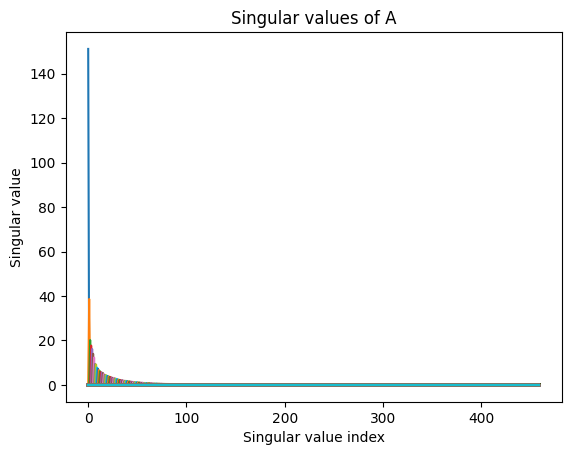

In [46]:
U, S, VT = np.linalg.svd(compute_kernel(embs))
print(f'U: {U.shape}\n')
print(f'S: {S.shape}\n')
print(f'VT: {VT.shape}\n')
plt.plot(np.diag(S))
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.title('Singular values of A')
plt.show()

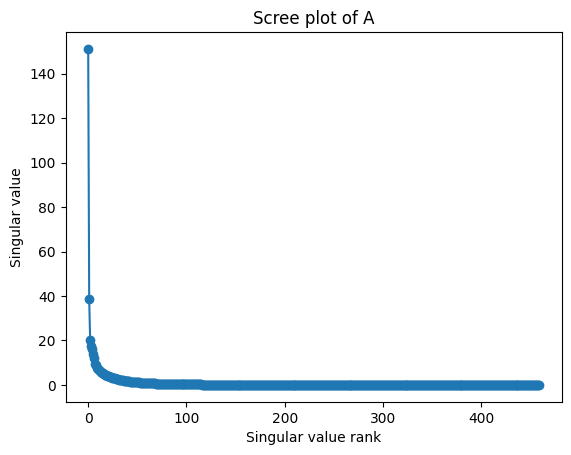

In [48]:
# Sort the singular values in descending order
s = S

# Plot the scree plot
plt.plot(S, 'o-')
plt.xlabel('Singular value rank')
plt.ylabel('Singular value')
plt.title('Scree plot of A')
plt.show()

U: (460, 460)

S: (460,)

VT: (460, 460)



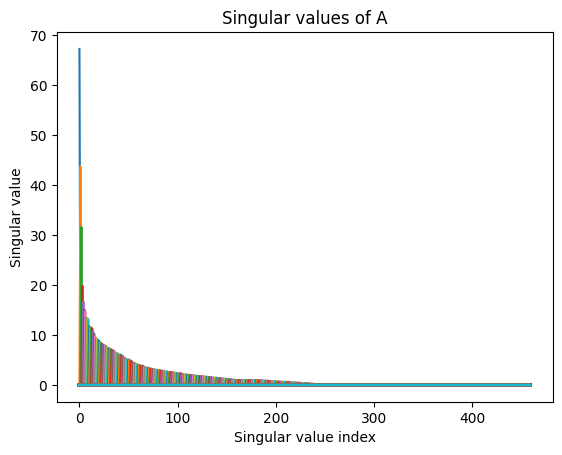

In [49]:
U, S, VT = np.linalg.svd(A)
print(f'U: {U.shape}\n')
print(f'S: {S.shape}\n')
print(f'VT: {VT.shape}\n')
plt.plot(np.diag(S))
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.title('Singular values of A')
plt.show()

U: (460, 460)

S: (460,)

VT: (460, 460)



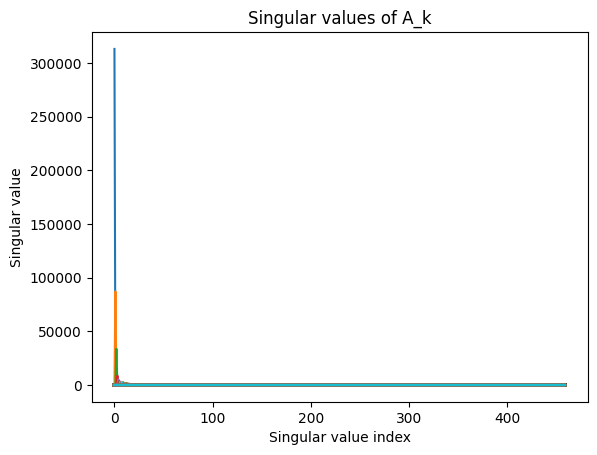

In [56]:
U, S, VT = np.linalg.svd(A_k)
print(f'U: {U.shape}\n')
print(f'S: {S.shape}\n')
print(f'VT: {VT.shape}\n')
plt.plot(np.diag(S))
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.title('Singular values of A_k')
plt.show()

In [29]:
L, D = graph_laplacian(A)
L_k, D_k = graph_laplacian(A_k)

U: (460, 460)

S: (460,)

VT: (460, 460)



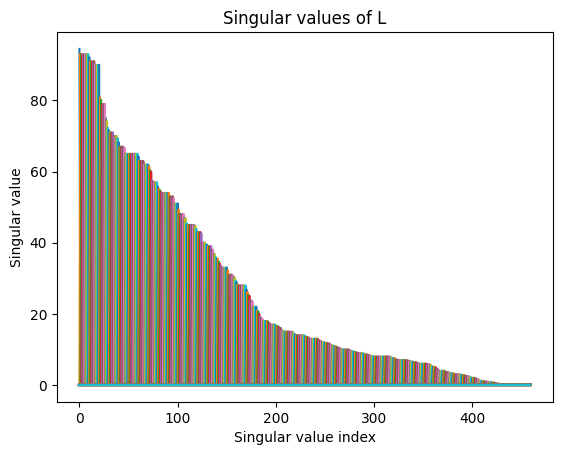

In [57]:
U, S, VT = np.linalg.svd(L)
print(f'U: {U.shape}\n')
print(f'S: {S.shape}\n')
print(f'VT: {VT.shape}\n')
plt.plot(np.diag(S))
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.title('Singular values of L')
plt.show()

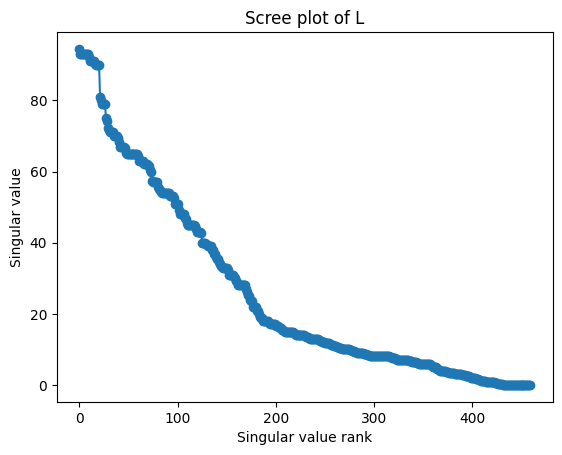

In [58]:
# Plot the scree plot
plt.plot(S, 'o-')
plt.xlabel('Singular value rank')
plt.ylabel('Singular value')
plt.title('Scree plot of L')
plt.show()

Singular values of graph laplacian 

U: (460, 460)

S: (460,)

VT: (460, 460)



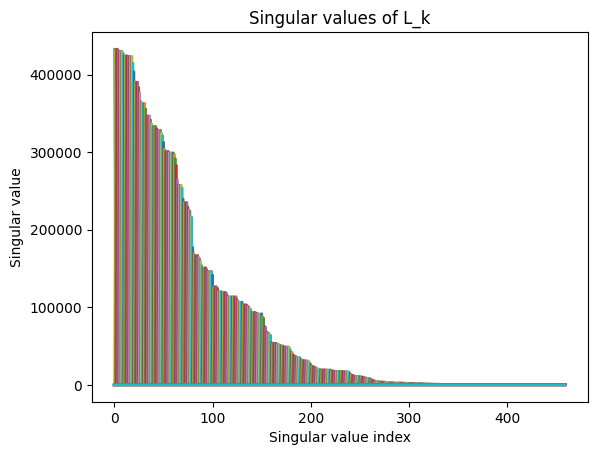

In [59]:
U, S, VT = np.linalg.svd(L_k)
print(f'U: {U.shape}\n')
print(f'S: {S.shape}\n')
print(f'VT: {VT.shape}\n')
plt.plot(np.diag(S))
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.title('Singular values of L_k')
plt.show()

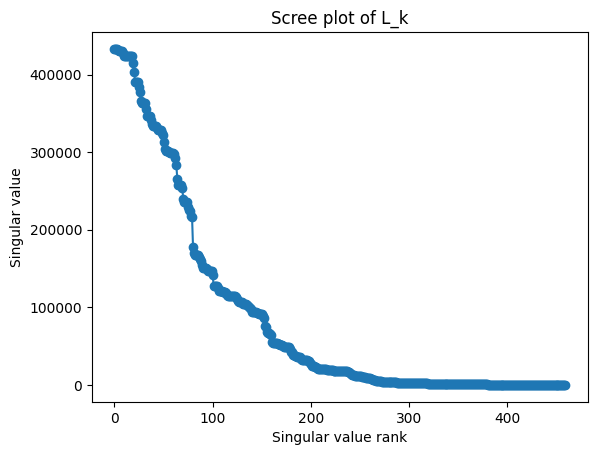

In [60]:
# Plot the scree plot
plt.plot(S, 'o-')
plt.xlabel('Singular value rank')
plt.ylabel('Singular value')
plt.title('Scree plot of L_k')
plt.show()

In [30]:
D

array([[20.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  8.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., 10., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  6.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., 30.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0., 45.]])

In [32]:
diagonal_sum = np.trace(D)
diagonal_sum

12436.0

In [31]:
D_k

array([[  4749.,      0.,      0., ...,      0.,      0.,      0.],
       [     0.,    887.,      0., ...,      0.,      0.,      0.],
       [     0.,      0.,   5012., ...,      0.,      0.,      0.],
       ...,
       [     0.,      0.,      0., ...,    316.,      0.,      0.],
       [     0.,      0.,      0., ...,      0.,  47880.,      0.],
       [     0.,      0.,      0., ...,      0.,      0., 107058.]])

In [33]:
diagonal_sum_k = np.trace(D_k)
diagonal_sum_k

40063996.0

In [26]:


def load_topic_model(diversity=0.1, min_topic_size=10):
    vectorizer_model = CountVectorizer(stop_words="english")
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
    representation_model = OpenAI(model="gpt-3.5-turbo", delay_in_seconds=1, chat=True)
    model = SentenceTransformer(MODEL_NAME)
    #representation_model = MaximalMarginalRelevance(diversity=diversity)
    topic_model = BERTopic(
        nr_topics="auto",
        min_topic_size=min_topic_size,
        representation_model=representation_model,
        vectorizer_model=vectorizer_model,
        ctfidf_model=ctfidf_model,
        embedding_model=model,
    )
    return topic_model


def fit_topic_model(topic_model, data, embeddings, key="query"):
    topics, probs = topic_model.fit_transform(data[key].to_list(), embeddings)
    return topics, probs


def get_topic_info(topic_model):
    return topic_model.get_topic_info()


def reduce_topics(topic_model, data, nr_topics, key="query"):
    topic_model.reduce_topics(data[key].to_list(), nr_topics)
    return topic_model


def get_representative_docs(topic_model):
    return topic_model.get_representative_docs()


def reduce_outliers(topic_model, data, topics, probs, key="query", strategy="c-tf-idf"):
    vectorizer_model = CountVectorizer(stop_words="english")
    ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
    representation_model = OpenAI(model="gpt-3.5-turbo", delay_in_seconds=1, chat=True)
    #representation_model = MaximalMarginalRelevance(diversity=diversity)
    if strategy == "c-tf-idf":
        new_topics = topic_model.reduce_outliers(data[key].to_list(), topics, strategy, threshold=0.1)
    elif strategy == "embeddings":
        new_topics = topic_model.reduce_outliers(data[key].to_list(), topics, strategy)
    elif strategy == "distributions":
        new_topics = topic_model.reduce_outliers(data[key].to_list(), topics, probabilities=probs, strategy=strategy)
    else:
        raise ValueError("Invalid strategy")
    topic_model.update_topics(data[key].to_list(), topics=new_topics, representation_model=representation_model, vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model)
    return topic_model, new_topics


def compute_hierarchical_topic_tree(topic_model, data, key="query"):
    hierarchical_topics = topic_model.hierarchical_topics(data[key].to_list())
    tree = topic_model.get_topic_tree(hierarchical_topics)
    return hierarchical_topics, tree

In [ ]:


topic_model = load_topic_model()
topics, probs = fit_topic_model(topic_model, data, agg_features)
freq = get_topic_info(topic_model)
rep_docs = get_representative_docs(topic_model)
freq


Embedding data
Model loaded
Unique sentences 231


Batches: 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]


Embeddings computed


100%|██████████| 2/2 [00:00<00:00, 123.12it/s]


,Topic,Count,Name
0,-1,8,-1_Improving the Robustness of HDBSCAN-like Cl...
1,0,110,"0_Improving Logging Class, Dimensionality Redu..."
2,1,50,1_Improving BERTopic Code and Visualization th...
3,2,50,2_Suggestions to improve Scikit-Learn based em...
4,3,13,3_Refactoring and improving function documenta...


In [ ]:
hr, tree = compute_hierarchical_topic_tree(topic_model=topic_model, data=data)

100%|██████████| 3/3 [00:04<00:00,  1.60s/it]


In [ ]:
print(tree)

.
├─■──Refactoring and improving function documentation and error handling____ ── Topic: 3
└─Code documents and embeddings in topic modeling pipeline____
     ├─■──Improving BERTopic Code and Visualization through Functionality Updates and Customization____ ── Topic: 1
     └─Code organization and improvement suggestions for embedding models____
          ├─■──Improving Logging Class, Dimensionality Reduction Class and Zero-Shot Classification Exception Handl ── Topic: 0
          └─■──Suggestions to improve Scikit-Learn based embedding model in Python codebase____ ── Topic: 2

